# Face Detection
##### by Chris Miller

The purpose of this notebook is to train a model to detect the presence of faces in an image.  Useful for things like Facebook tagging, cellphone cameras seeking to find faces to focus on, etc.  I'm doing this mostly as an exercise to learn Keras/Tensorflow, since I've not used an artificial neural network since Theano was was envogue, and my understanding is Keras is the next wave.

Let's start with the imports.

In [229]:
# Imports

# Scientific imports
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from scipy import stats
from keras import models

# Administrivium imports
import json
import requests
from os import path
import pickle
from random import shuffle
from functools import reduce

# Image imports
import imageio
from io import BytesIO

%matplotlib inline

The next section is where I'll put any general, highly reusable code for ease of access.  It won't be specific to this project.

In [245]:
# Functional Abstractions

def coordinate_range(max_x, max_y):
    """Returns a one dimensional list of 2 dimensional coordinates from (0,0) to (max_x, max_y)."""
    return [(x, y) for y in range(max_y) for x in range(max_x)]

def add_fields(data, **kwargs):
    """Add new data to an existing JSON dataset."""
    new_data = [[{k: v} for v in kwargs[k]] for k in kwargs]
    return [reduce(lambda a,b: {**a, **b}, d) for d in zip(data, *new_data)]

def http_get(http_string):
    "Download the data located at a valid url"
    request = requests.get(http_string)
    if request.status_code < 400:
        return request.content
    else:
        return None

Image processing functions are next.  These will be the things necessary to download and convert all the image data into things that are useful for this project.  They're written with reusability in mind, but are more specific to this project than the functions above.

In [225]:
# Image Processing Functions        

def read_jpg(jpg_bytes):
    "Convert a jpg into a numpy array"
    _bytes = BytesIO(jpg_bytes)
    return imageio.imread(_bytes)


def fetch_images(data):
    """Assuming there is a field called `content` in the JSON, downloads the data in bulk, then pickles it."""
    images = [http_get(d["content"]) for d in data]
    pickle.dump(images, open("images.pickle", "wb"))
    return images


def make_rectangle(lower_left, upper_right):
    """Turn two coordinates into the format for use with pyplot's patches.Rectangle class"""
    width = upper_right["x"] - lower_left["x"]
    height = upper_right["y"] - lower_left["y"]
    return {"xy": (lower_left["x"], lower_left["y"]), "width": width, "height": height}


def adjust_dimensions(annotation):
    lower_left = {"x": annotation["points"][0]["x"] * annotation["imageWidth"],
                  "y": annotation["points"][0]["y"] * annotation["imageHeight"]}
    upper_right = {"x": annotation["points"][1]["x"] * annotation["imageWidth"],
                  "y": annotation["points"][1]["y"] * annotation["imageHeight"]}
    return lower_left, upper_right


def get_rectangles(annotations):
    """Uses the `annotation` field to create rectangles for use on images"""
    return [make_rectangle(*adjust_dimensions(annotation)) for annotation in annotations]
    

Now it's time to download the data.  The dataset isn't particularly huge (only 500 records), but the images must be downloaded separately, which takes quite a while.  So, the fetch_images(data) function will pickle the results for future access so I've only got to download them once.  

In [226]:
# Data
with open("face_detection.json", 'r') as fr:
    data = [json.loads(record) for record in fr.readlines()]

# Lengthy download - don't run if the pickle is present.
image_bytes = pickle.load(open("images.pickle", 'rb')) if path.isfile("images.pickle") else fetch_images(data)

# Convert all the image byte files into np.arrays
images = [read_jpg(img) for img in image_bytes]

# Dig through the training labels to extract the information necessary to overlay the labels on top of the images
rectangles = [get_rectangles(d["annotation"]) for d in data]

Let's see what the data look like now.  I'll just look at the first sample to get an idea of its contents.

In [219]:
# Inspect the meta data
data[0]

{'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'annotation': [{'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
   'imageWidth': 650,
   'imageHeight': 333},
  {'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
   'imageWidth': 650,
   'imageHeight': 333}],
 'extras': None}

Now, we need to combine the data into one dataset and taking a look at its contents. Since we've already done a bit of preprocessing, it's worth, at this point, pickling the data again.

In [244]:
if path.isfile("full_data.pickle"):
    full_data = pickle.load(open("full_data.pickle", "rb"))
else:
    full_data = add_fields(data, image=images, rectangles=rectangles)
    pickle.dump(full_data, open("full_data.pickle", "wb"))

full_data[0]

{'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'annotation': [{'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
   'imageWidth': 650,
   'imageHeight': 333},
  {'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
   'imageWidth': 650,
   'imageHeight': 333}],
 'extras': None,
 'image': Array([[[42, 37, 34],
         [56, 51, 48],
         [71, 66, 63],
         ...,
         [23, 33, 34],
         [26, 36, 37],
         [28, 38, 39]],
 
        [[40, 35, 32],
         [51, 46, 43],
         [64, 59, 56],
         ...,
         [27, 36, 35],
         [24, 33, 32],
         [26, 35, 34]],
 
        [[43, 38, 35],
         [51, 46, 43],
         [61, 56, 53],
         ...

Now it's time to inspect the images, and make sure the rectangles properly align with the faces they're meant to highlight.

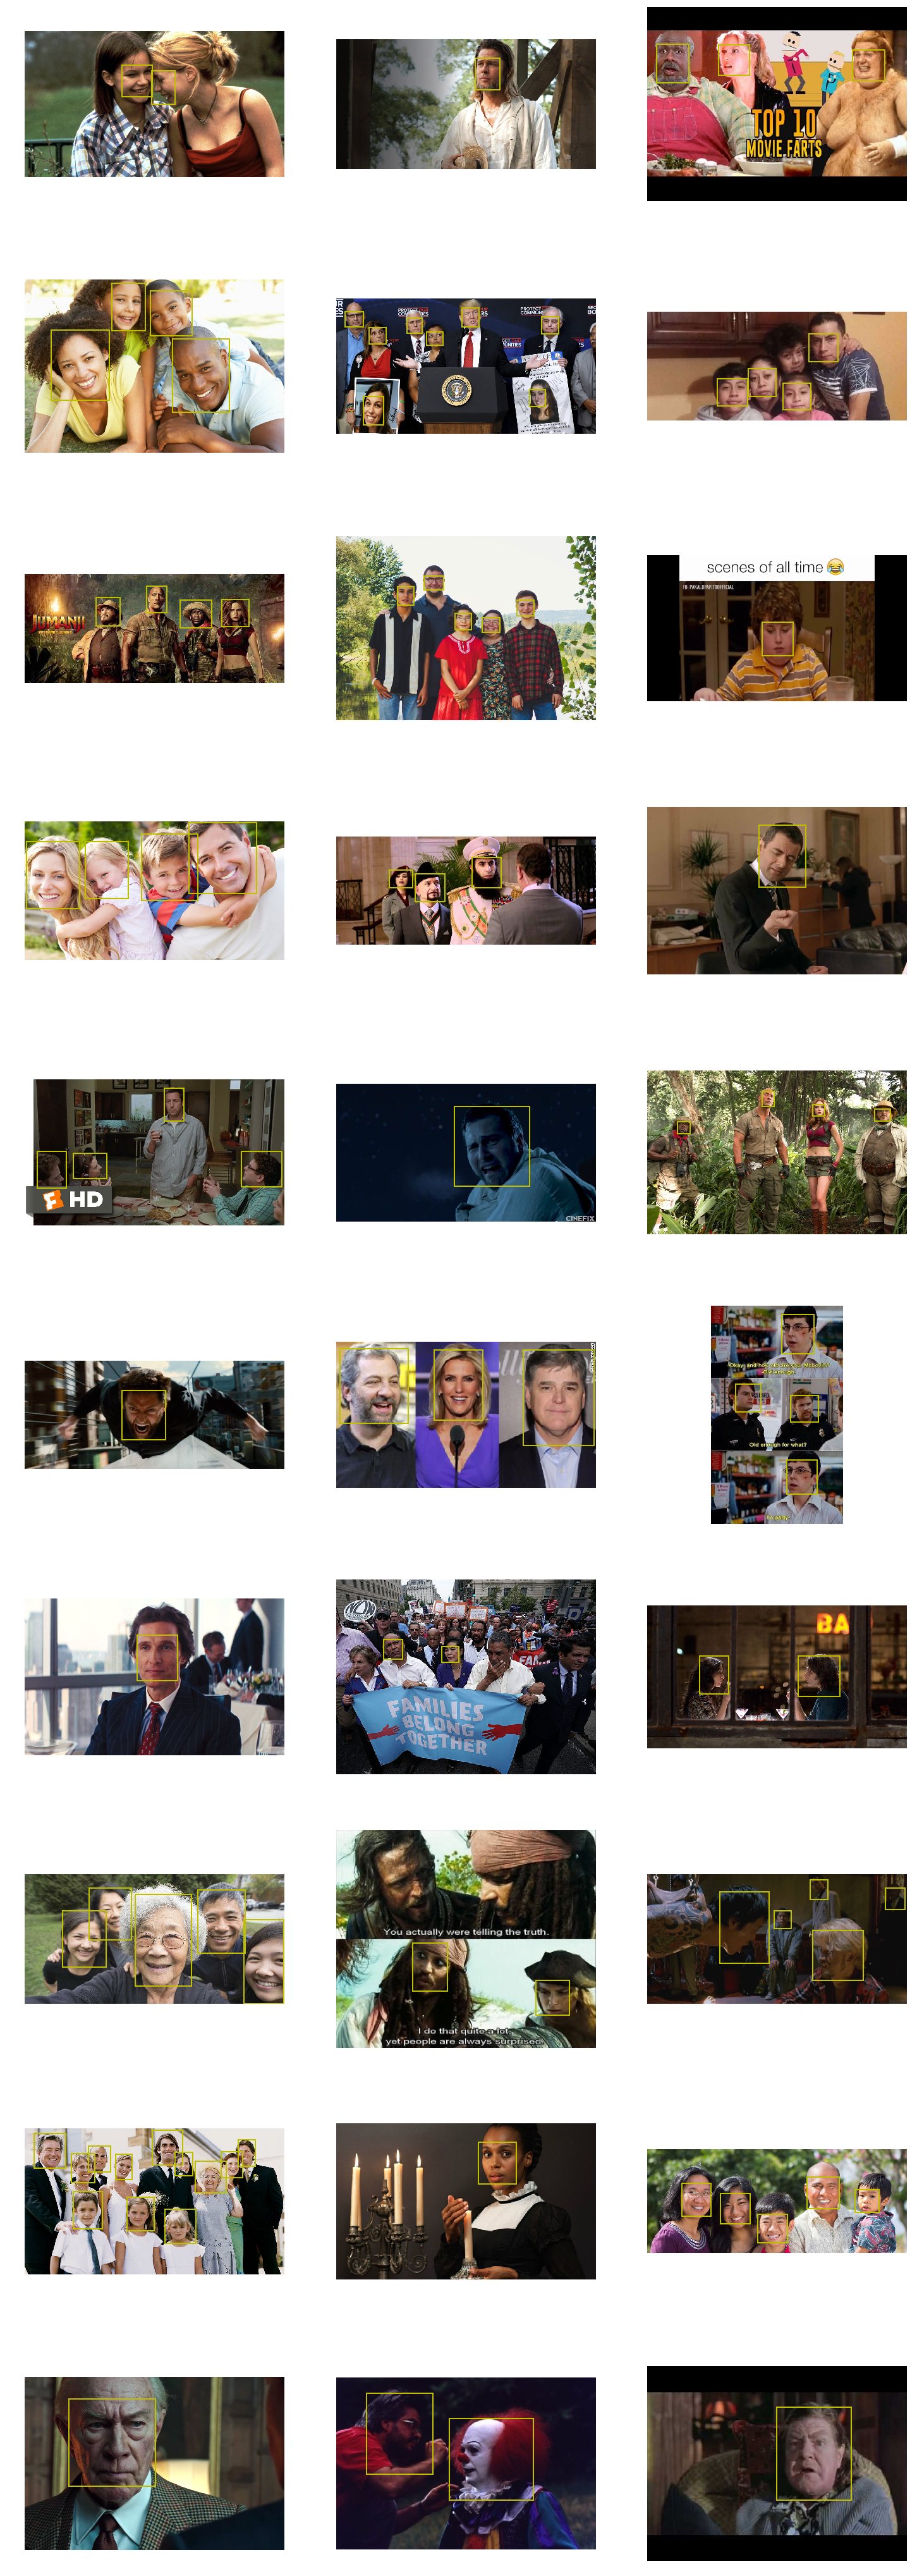

In [306]:
# Inspect a sample of images

indices = [i for i in range(409)]
shuffle(indices)

viewing_order = (i for i in indices)

fig1, ax1 = plt.subplots(10, 3, figsize=(25, 75))

for c in coordinate_range(10, 3):
    i = next(viewing_order)
    ax1[c].axis("off")
    ax1[c].imshow(full_data[i]["image"])
    
    for r in full_data[i]["rectangles"]:
        rect = Rectangle(xy=r["xy"], width=r["width"], height=r["height"], linewidth=2, edgecolor='y', fill=False)
        ax1[c].add_patch(rect)


Now it's time for a quick statistical analysis of the data.  First, I'd like to examine the distribution of colors across all images.  I'm expecting a high degree of positive skewness in the data, which may require some normalization as part of the preparatory work.

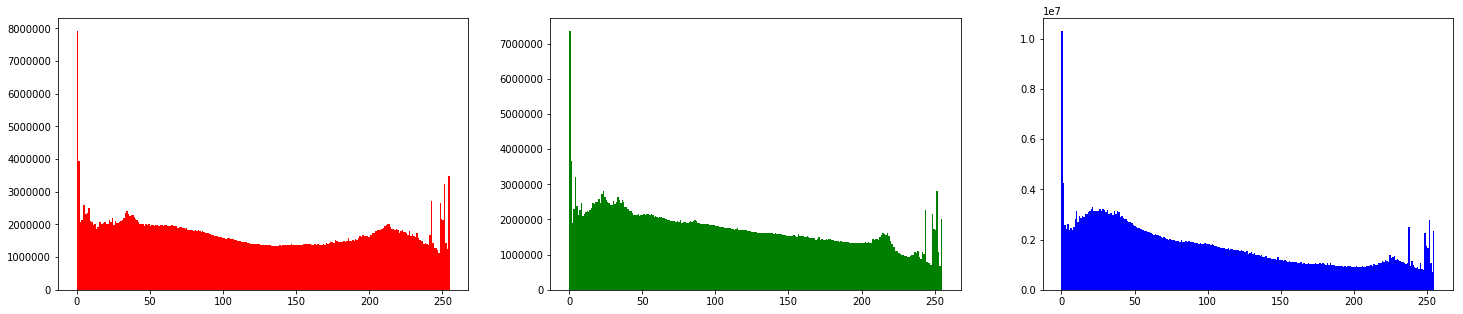

In [319]:
red = [img[:,:,0] for img in images]
green = [img[:,:,1] for img in images]
blue = [img[:,:,2] for img in images]

red_pixels = np.concatenate([img.flatten() for img in red])
green_pixels = np.concatenate([img.flatten() for img in green])
blue_pixels = np.concatenate([img.flatten() for img in blue])

fig2, ax2 = plt.subplots(1, 3, figsize=(25, 5))

ax2[0].hist(red_pixels, bins=256, color="r")
ax2[1].hist(green_pixels, bins=256, color="g")
ax2[2].hist(blue_pixels, bins=256, color="b")
fig2.show()